In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import LabelEncoder
import json
import pickle

df = pd.read_csv("Datathon Dataset.csv")
df_cleaned = df.drop(columns=["Unnamed: 0", "Un_Named", "Customer_Id"], errors='ignore')
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"], errors="coerce")
df_cleaned = df_cleaned.dropna(subset=["Date"])
mode_series = df_cleaned["Infrastructure_Machineries"].mode()
if not mode_series.empty:
    mode_value = mode_series.iloc[0]
else:
    mode_value = "Unknown"
df_cleaned["Infrastructure_Machineries"] = df_cleaned["Infrastructure_Machineries"].fillna(mode_value)
df_cleaned["Year"] = df_cleaned["Date"].dt.year
df_cleaned["Month"] = df_cleaned["Date"].dt.month
df_cleaned["Day"] = df_cleaned["Date"].dt.day
df_cleaned["DayOfWeek"] = df_cleaned["Date"].dt.dayofweek
le_mach = LabelEncoder()
df_cleaned["Machinery_Code"] = le_mach.fit_transform(df_cleaned["Infrastructure_Machineries"])
le_region = LabelEncoder()
df_cleaned["Region_Code"] = le_region.fit_transform(df_cleaned["Region"])
df_cleaned.to_csv('cleaned_1.csv', index=False)
print("Cleaned data saved to cleaned_1.csv")
features = [
    "Daily_Sales _Percentage", "Market_Share", "Political", "Marketing", "Budget",
    "Year", "Month", "Day", "DayOfWeek", "Machinery_Code", "Region_Code"
]
target = "Daily_Sales_Quantity"
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
manual_mae = np.mean(np.abs(y_test - y_pred))/10
manual_rmse = np.sqrt(np.mean((y_test - y_pred)**2))/10
r2 = r2_score(y_test, y_pred)
print("\nModel Evaluation Metrics:")
print("MAE:", manual_mae)
print("RMSE:", manual_rmse)
print("R² Score:", r2)
threshold = np.median(y_test)
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)
f1 = f1_score(y_test_binary, y_pred_binary)
print("\nF1 Score (after binarization):", f1)
df_region_eval = X_test.copy()
df_region_eval["Actual"] = y_test
df_region_eval["Predicted"] = y_pred
df_region_eval["Region_Name"] = le_region.inverse_transform(df_region_eval["Region_Code"])
region_analysis = df_region_eval.groupby("Region_Name").agg({"Actual": "mean", "Predicted": "mean"})
saved_objects = {
    "model": model,
    "machinery_encoder": le_mach,
    "region_encoder": le_region
}
with open("best_model.pkl", "wb") as f:
    pickle.dump(saved_objects, f)
forecast_days = 30
safety_margin = 0.10
future_dates = pd.date_range(start=df_cleaned["Date"].max() + pd.Timedelta(days=1),
                             periods=forecast_days, freq="D")
machine_types = le_mach.classes_
forecast_results = {}
avg_features = {
    "Daily_Sales _Percentage": df_cleaned["Daily_Sales _Percentage"].mean(),
    "Market_Share": df_cleaned["Market_Share"].mean(),
    "Budget": df_cleaned["Budget"].mean()
}
political_mode = df_cleaned["Political"].mode().iloc[0]
marketing_mode = df_cleaned["Marketing"].mode().iloc[0]
common_region_code = df_cleaned["Region_Code"].mode().iloc[0]
for machine in machine_types:
    machinery_code = le_mach.transform([machine])[0]
    rows = []
    for date in future_dates:
        row = {
            "Daily_Sales _Percentage": avg_features["Daily_Sales _Percentage"],
            "Market_Share": avg_features["Market_Share"],
            "Political": political_mode,
            "Marketing": marketing_mode,
            "Budget": avg_features["Budget"],
            "Year": date.year,
            "Month": date.month,
            "Day": date.day,
            "DayOfWeek": date.dayofweek,
            "Machinery_Code": machinery_code,
            "Region_Code": common_region_code
        }
        rows.append(row)
    future_df = pd.DataFrame(rows)
    future_df["Predicted_Daily_Demand"] = model.predict(future_df)
    total_demand = future_df["Predicted_Daily_Demand"].sum()
    total_demand_with_safety = total_demand * (1 + safety_margin)
    forecast_results[machine] = total_demand_with_safety
print("\nForecasted 30-day Demand (with safety margin):")
print(json.dumps(forecast_results, indent=4))
storage_requirements = {
    "Backhoe Loader": 15,
    "Excavators(crawler)": 25,
    "Loaders (Wheeled)": 20,
    "Skid Steer Loaders": 10,
    "Compactors": 12,
    "Tele Handlers ": 18
}
machine_mapping = {
    "Backhoe Loader": "Backhoe Loader",
    "Compactors": "Compactors",
    "Excavators(crawler)": "Excavators(crawler)",
    "Loaders (Wheeled)": "Loaders (Wheeled)",
    "Skid Steer Loaders": "Skid Steer Loaders",
    "Tele Handlers ": "Tele Handlers "
}
unit_costs = {
    "Backhoe Loader": 3000000,
    "Excavators(crawler)": 5000000,
    "Loaders (Wheeled)": 4000000,
    "Skid Steer Loaders": 2000000,
    "Compactors": 2500000,
    "Tele Handlers ": 3500000
}
desired_inventory = {}
for machine, demand in forecast_results.items():
    if machine not in machine_mapping:
        continue
    desired_inventory[machine] = int(np.ceil(demand))
print("\nDesired Inventory Levels (pre-scaling):")
print(json.dumps(desired_inventory, indent=4))
total_storage_required = sum(desired_inventory[machine] * storage_requirements.get(machine, 0)
                             for machine in desired_inventory)
print(f"\nTotal Storage Required (pre-scaling): {total_storage_required} cubic meters")


/var/folders/n3/8ftnct8j2lj8_z56tctdnm7c0000gn/T/ipykernel_19815/4163619248.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"], errors="coerce")


Cleaned data saved to cleaned_1.csv

Model Evaluation Metrics:
MAE: 0.8514392764857881
RMSE: 1.077045054348056
R² Score: 0.9998153103718647

F1 Score (after binarization): 0.9623655913978495

Forecasted 30-day Demand (with safety margin):
{
    "Backhoe Loader": 606.9800000000001,
    "Compactors": 634.5020000000001,
    "Excavators(crawler)": 657.8879999999999,
    "Loaders (Wheeled)": 624.184,
    "Skid Steer Loaders": 611.633,
    "Tele Handlers ": 574.0790000000001,
    "invalid_data": 556.0500000000001
}

Desired Inventory Levels (pre-scaling):
{
    "Backhoe Loader": 607,
    "Compactors": 635,
    "Excavators(crawler)": 658,
    "Loaders (Wheeled)": 625,
    "Skid Steer Loaders": 612,
    "Tele Handlers ": 575
}

Total Storage Required (pre-scaling): 62145 cubic meters


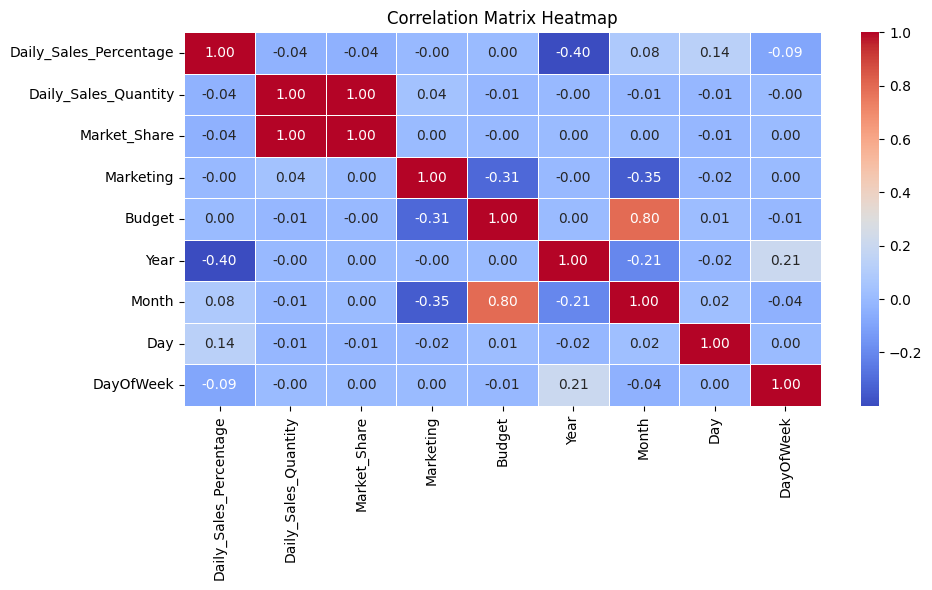

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "cleaned_1.csv"
df = pd.read_csv(file_path)

df.rename(columns={"Daily_Sales _Percentage": "Daily_Sales_Percentage"}, inplace=True)

numeric_columns = [
    "Daily_Sales_Percentage", "Daily_Sales_Quantity", 
    "Market_Share", "Marketing", "Budget", "Year", "Month", "Day", "DayOfWeek"
]

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()

plt.savefig("correlation_heatmap.png")

plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import LabelEncoder
import json
import pickle

df_test = pd.read_csv("input_data.csv")
df_test.columns = df_test.columns.str.strip()
print("Test Data Columns:", df_test.columns.tolist())
print("Test Data Sample:")
print(df_test.head())

df_test["Date"] = pd.to_datetime(df_test["Date"], format="%d-%m-%Y", errors="coerce")
df_test = df_test.dropna(subset=["Date"])

mode_series = df_test["Infrastructure_Machineries"].mode()
mode_value = mode_series.iloc[0] if not mode_series.empty else "Unknown"
df_test["Infrastructure_Machineries"] = df_test["Infrastructure_Machineries"].fillna(mode_value)

df_test["Year"] = df_test["Date"].dt.year
df_test["Month"] = df_test["Date"].dt.month
df_test["Day"] = df_test["Date"].dt.day
df_test["DayOfWeek"] = df_test["Date"].dt.dayofweek

with open("best_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)

model = saved_objects["model"]
le_mach = saved_objects["machinery_encoder"]
le_region = saved_objects["region_encoder"]

df_test["Machinery_Code"] = le_mach.transform(df_test["Infrastructure_Machineries"])

def safe_transform_region(x, encoder, default_value):
    if x in encoder.classes_:
        return encoder.transform([x])[0]
    else:
        return default_value

default_region_value = le_region.transform([le_region.classes_[0]])[0]
df_test["Region_Code"] = df_test["Region"].apply(lambda x: safe_transform_region(x, le_region, default_region_value))

features = [
    "Daily_Sales _Percentage", "Market_Share", "Political", "Marketing", "Budget",
    "Year", "Month", "Day", "DayOfWeek", "Machinery_Code", "Region_Code"
]
X_test = df_test[features]

df_test["Predicted_Demand"] = model.predict(X_test)

output_columns = ["Customer_Id", "Predicted_Demand"] if "Customer_Id" in df_test.columns else ["Predicted_Demand"]
output = df_test[output_columns]

print("\nPredicted Demand for Test Data:")
print(output)

output.to_csv("predicted_output.csv", index=False)

inventory_forecast = df_test.groupby("Infrastructure_Machineries")["Predicted_Demand"].sum()
desired_inventory = {machine: int(np.ceil(demand)) for machine, demand in inventory_forecast.items()}
print("\nDesired Inventory Levels (pre-scaling):")
print(json.dumps(desired_inventory, indent=4))

storage_requirements = {
    "Backhoe Loader": 15,
    "Excavators(crawler)": 25,
    "Loaders (Wheeled)": 20,
    "Skid Steer Loaders": 10,
    "Compactors": 12,
    "Tele Handlers ": 18
}

total_storage_required = 0
for machine, units in desired_inventory.items():
    if machine in storage_requirements:
        total_storage_required += units * storage_requirements[machine]
    else:
        print(f"Warning: No storage requirement defined for {machine}")
print(f"\nTotal Storage Required (pre-scaling): {total_storage_required} cubic meters")

total_available_storage = 5000
if total_storage_required <= total_available_storage:
    optimized_inventory = desired_inventory
else:
    scaling_factor = total_available_storage / total_storage_required
    optimized_inventory = {machine: int(np.floor(units * scaling_factor))
                           for machine, units in desired_inventory.items()}

optimized_storage = sum(
    optimized_inventory[machine] * storage_requirements.get(machine, 0)
    for machine in optimized_inventory
)
print(f"\nOptimized Total Storage: {optimized_storage} cubic meters")

print("\nOptimized Inventory Levels (after applying storage constraint):")
print(json.dumps(optimized_inventory, indent=4))

unit_costs = {
    "Backhoe Loader": 3000000,
    "Excavators(crawler)": 5000000,
    "Loaders (Wheeled)": 4000000,
    "Skid Steer Loaders": 2000000,
    "Compactors": 2500000,
    "Tele Handlers ": 3500000
}

individual_costs = {machine: optimized_inventory[machine] * unit_costs.get(machine, 0)
                    for machine in optimized_inventory}

total_cost = sum(individual_costs.values())

print("\nIndividual Costs per Machinery Type:")
print(json.dumps(individual_costs, indent=4))
print(f"\nTotal Inventory Cost: ₹{total_cost:,}")


Test Data Columns: ['Customer_Id', 'Date', 'Daily_Sales _Percentage', 'Market_Share', 'Political', 'Marketing', 'Budget', 'Infrastructure_Machineries', 'Region']
Test Data Sample:
  Customer_Id        Date  Daily_Sales _Percentage  Market_Share  Political  \
0   CUST00001  01-01-2025                 0.034464            35          1   
1   CUST00002  01-01-2025                 0.034464            35          1   
2   CUST00003  01-01-2025                 0.034464            35          1   
3   CUST00004  01-01-2025                 0.034464            35          1   
4   CUST00007  01-01-2025                 0.034464            35          1   

   Marketing   Budget Infrastructure_Machineries                  Region  
0          1  5000.56                 Compactors        South Justinstad  
1          1  5000.56          Loaders (Wheeled)           Sherrichester  
2          1  5000.56         Skid Steer Loaders          North Ryanstad  
3          1  5000.56             Backhoe Loa